# Scaling

## DIALS IO

``ess.nmx`` has ``dials`` IO helper functions.

They can be used as providers in a workflow of scaling routine.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [39]:
import gemmi
import pathlib

from ess.nmx.dials_io import (
read_dials_reflection_file,
read_dials_experiment_file,
dials_refl_to_pandas,
DialsReflectionFilePath,
DialsExperimentFilePath,
get_space_group,
DialsDataFrame
)

# from ess.nmx.data import get_small_random_mtz_samples
# small_mtz_sample = get_small_random_mtz_samples()[0]
dials_refls = pathlib.Path('/Users/aaronfinke/nmx_mcstas/cluster_output/rubredoxin_phiseries/5e11_nozeroes/dials/integrated.refl')
dials_expt = pathlib.Path('/Users/aaronfinke/nmx_mcstas/cluster_output/rubredoxin_phiseries/5e11_nozeroes/dials/integrated.expt')

# df = dials_refl_to_pandas(dials_refl)
# df.head()

## Build Pipeline

Scaling routine includes:
- Reducing individual MTZ dataset
- Merging MTZ dataset 
- Reducing merged MTZ dataset

These operations are done on pandas dataframe as recommended in ``gemmi``.
And multiple MTZ files are expected, so we need to use ``sciline.ParamTable``.
<!--TODO: Update it to use cyclebane instead of ParamTable if needed.-->

In [53]:
import pandas as pd
import sciline as sl
import scipp as sc

from ess.nmx.dials_io import providers as dials_io_providers, default_parameters as dials_io_params
from ess.nmx.dials_io import SpaceGroupDesc
from ess.nmx.scaling import providers as scaling_providers, default_parameters as scaling_params
from ess.nmx.scaling import (
    WavelengthBins,
    WavelengthBinned,
    FilteredEstimatedScaledIntensities,
    ReferenceWavelength,
    ScaledIntensityLeftTailThreshold,
    ScaledIntensityRightTailThreshold,
)
pl = None
pl = sl.Pipeline(
    providers=dials_io_providers + scaling_providers,
    params={
        SpaceGroupDesc: "P 21 21 21",
        ReferenceWavelength: sc.scalar(
            2.68, unit=sc.units.angstrom
        ),  # Remove it if you want to use the middle of the bin
        # ScaledIntensityLeftTailThreshold: sc.scalar(
        #     0.1,  # Increase it to remove more outliers
        # ),
        # ScaledIntensityRightTailThreshold: sc.scalar(
        #     4.0,  # Decrease it to remove more outliers
        # ),
        DialsReflectionFilePath: dials_refls,
        DialsExperimentFilePath: dials_expt,
        **dials_io_params,
        **scaling_params,
        # WavelengthBins: 250,
    },
)
pl[WavelengthBins] = sc.linspace(dim='wavelength', start=1.8, stop=3.55, num=251, unit=sc.units.angstrom)
pl.compute(WavelengthBinned)

<scipp.DataArray>
Dimensions: Sizes[wavelength:250, ]
Coordinates:
* wavelength                float64             [Å]  (wavelength [bin-edge])  [1.8, 1.807, ..., 3.543, 3.55]
Data:
                          DataArrayView        <no unit>  (wavelength)  binned data: dim='row', content=DataArray(
          dims=(row: 25642),
          data=float64[dimensionless],
          coords={'H':int64, 'K':int64, 'L':int64, 'hkl':string, 'd':float64,
                  'wavelength':float64[Å], 'hkl_asu':string, 'H_ASU':int64,
                  'K_ASU':int64, 'L_ASU':int64})

## Build Workflow

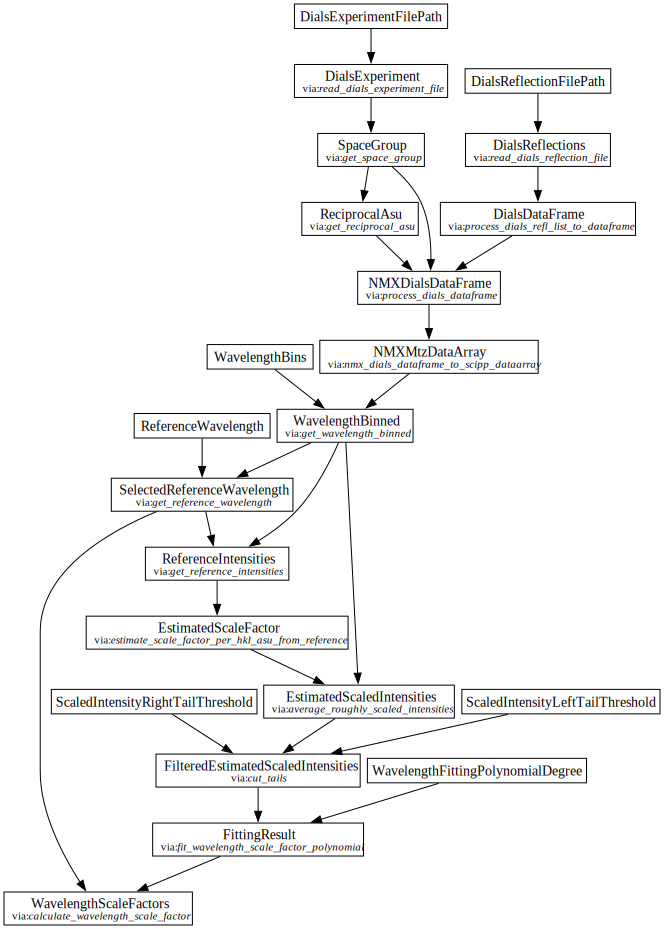

In [54]:
from ess.nmx.scaling import WavelengthScaleFactors

scaling_nmx_workflow = pl.get(WavelengthScaleFactors)
scaling_nmx_workflow.visualize(graph_attr={"rankdir": "UD"})

## Compute Desired Type

In [55]:
from ess.nmx.scaling import (
    SelectedReferenceWavelength,
    FittingResult,
    WavelengthScaleFactors,
)

results = scaling_nmx_workflow.compute(
    (
        FilteredEstimatedScaledIntensities,
        SelectedReferenceWavelength,
        FittingResult,
        WavelengthScaleFactors,
    )
)

results[WavelengthScaleFactors]


<scipp.DataArray>
Dimensions: Sizes[wavelength:84, ]
Coordinates:
* wavelength                float64             [Å]  (wavelength)  [1.8665, 1.9575, ..., 3.5325, 3.5465]
Data:
                            float64  [dimensionless]  (wavelength)  [-0.0250816, 0.225624, ..., 0.626562, 0.54871]

In [56]:
results[FilteredEstimatedScaledIntensities]

<scipp.DataArray>
Dimensions: Sizes[wavelength:84, ]
Coordinates:
* wavelength                float64             [Å]  (wavelength)  [1.8665, 1.9575, ..., 3.5325, 3.5465]
Data:
                            float64  [dimensionless]  (wavelength)  [0.164027, 0.141841, ..., 0.802455, 0.869509]  [7.94309e-08, 4.46628e-09, ..., 1.44445e-07, 6.87178e-08]

## Plots

Here are plotting examples of the fitting/estimation results.

### Estimated Scaled Intensities.

Text(0.5, 1.0, 'Filtered Estimated Scaled Intensities\nProbability Plot')

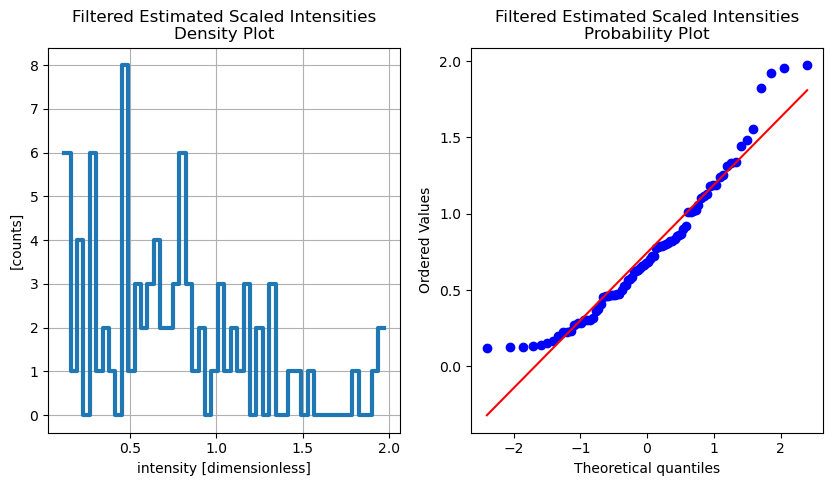

In [57]:
import scipy.stats as stats
import matplotlib.pyplot as plt

fig, (density_ax, prob_ax) = plt.subplots(1, 2, figsize=(10, 5))

densities = sc.values(results[FilteredEstimatedScaledIntensities].data).values
sc.values(results[FilteredEstimatedScaledIntensities].data).hist(intensity=50).plot(
    title="Filtered Estimated Scaled Intensities\nDensity Plot",
    grid=True,
    linewidth=3,
    ax=density_ax,
)
stats.probplot(densities, dist="norm", plot=prob_ax)
prob_ax.set_title("Filtered Estimated Scaled Intensities\nProbability Plot")

### Curve Fitting

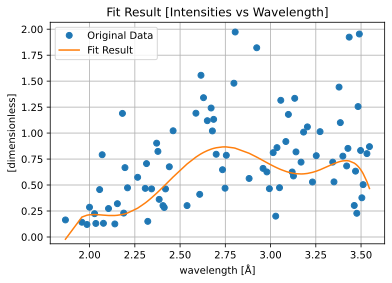

In [58]:
import plopp as pp
import numpy as np
from ess.nmx.scaling import FittingResult

chebyshev_func = np.polynomial.chebyshev.Chebyshev(np.array([1, -1, 1]))
scale_function = np.vectorize(
    chebyshev_func / chebyshev_func(results[SelectedReferenceWavelength].value)
)
pp.plot(
    {
        "Original Data": results[FilteredEstimatedScaledIntensities],
        "Fit Result": results[FittingResult].fit_output,
    },
    grid=True,
    title="Fit Result [Intensities vs Wavelength]",
    marker={"Chebyshev": None, "Fit Result": None},
    linestyle={"Chebyshev": "solid", "Fit Result": "solid"},
)

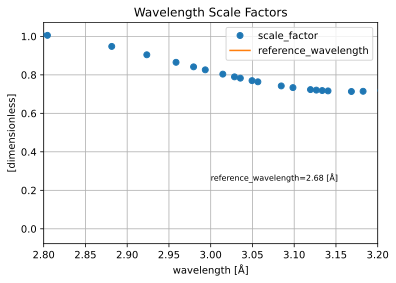

In [59]:
reference_wavelength = sc.DataArray(
    data=sc.concat(
        [
            results[WavelengthScaleFactors].data.min(),
            results[WavelengthScaleFactors].data.max(),
        ],
        "wavelength",
    ),
    coords={
        "wavelength": sc.broadcast(
            results[SelectedReferenceWavelength], dims=["wavelength"], shape=[2]
        )
    },
)
wavelength_scale_factor_plot = pp.plot(
    {
        "scale_factor": results[WavelengthScaleFactors],
        "reference_wavelength": reference_wavelength,
    },
    title="Wavelength Scale Factors",
    grid=True,
    marker={"reference_wavelength": None},
    linestyle={"reference_wavelength": "solid"},
)
wavelength_scale_factor_plot.ax.set_xlim(2.8, 3.2)
reference_wavelength = results[SelectedReferenceWavelength].value
wavelength_scale_factor_plot.ax.text(
    3.0,
    0.25,
    f"{reference_wavelength=:} [{results[SelectedReferenceWavelength].unit}]",
    fontsize=8,
    color="black",
)
wavelength_scale_factor_plot

## Change Provider
Here is an example of how to insert different filter function.

In this example, we will swap a provider that filters ``EstimatedScaledIntensities`` and provide ``FilteredEstimatedScaledIntensities``.

After updating the providers, you can go back to [Compute Desired Type](#Compute-Desired-Type) and start over.

In [60]:
from typing import NewType
import scipp as sc
from ess.nmx.scaling import (
    EstimatedScaledIntensities,
    FilteredEstimatedScaledIntensities,
)

# Define the new types for the filtering function
NRoot = NewType("NRoot", int)
"""The n-th root to be taken for the standard deviation."""
NRootStdDevCut = NewType("NRootStdDevCut", float)
"""The number of standard deviations to be cut from the n-th root data."""


def _calculate_sample_standard_deviation(var: sc.Variable) -> sc.Variable:
    """Calculate the sample variation of the data.

    This helper function is a temporary solution before
    we release new scipp version with the statistics helper.
    """
    import numpy as np

    return sc.scalar(np.nanstd(var.values))


# Define the filtering function with right argument types and return type
def cut_estimated_scaled_intensities_by_n_root_std_dev(
    scaled_intensities: EstimatedScaledIntensities,
    n_root: NRoot,
    n_root_std_dev_cut: NRootStdDevCut,
) -> FilteredEstimatedScaledIntensities:
    """Filter the mtz data array by the quad root of the sample standard deviation.

    Parameters
    ----------
    scaled_intensities:
        The scaled intensities to be filtered.

    n_root:
        The n-th root to be taken for the standard deviation.
        Higher n-th root means cutting is more effective on the right tail.
        More explanation can be found in the notes.

    n_root_std_dev_cut:
        The number of standard deviations to be cut from the n-th root data.

    Returns
    -------
    :
        The filtered scaled intensities.

    """
    # Check the range of the n-th root
    if n_root < 1:
        raise ValueError("The n-th root should be equal to or greater than 1.")

    copied = scaled_intensities.copy(deep=False)
    nth_root = copied.data ** (1 / n_root)
    # Calculate the mean
    nth_root_mean = nth_root.nanmean()
    # Calculate the sample standard deviation
    nth_root_std_dev = _calculate_sample_standard_deviation(nth_root)
    # Calculate the cut value
    half_window = n_root_std_dev_cut * nth_root_std_dev
    keep_range = (nth_root_mean - half_window, nth_root_mean + half_window)

    # Filter the data
    return FilteredEstimatedScaledIntensities(
        copied[(nth_root > keep_range[0]) & (nth_root < keep_range[1])]
    )


pl.insert(cut_estimated_scaled_intensities_by_n_root_std_dev)
pl[NRoot] = 4
pl[NRootStdDevCut] = 1.0

pl.compute(FilteredEstimatedScaledIntensities)

<scipp.DataArray>
Dimensions: Sizes[wavelength:71, ]
Coordinates:
* wavelength                float64             [Å]  (wavelength)  [1.9995, 2.0555, ..., 3.5325, 3.5465]
Data:
                            float64  [dimensionless]  (wavelength)  [0.286481, 0.456223, ..., 0.802455, 0.869509]  [4.42264e-09, 6.12918e-07, ..., 1.44445e-07, 6.87178e-08]